In [1]:
import numpy as np
import pandas as pd
from typing import Union
import string
import re
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score
import tensorflow_decision_forests as tfdf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nlp = spacy.load('en_core_web_sm')
pd.set_option('display.max_columns', None);

2024-02-11 22:01:45.633612: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-11 22:01:45.633685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-11 22:01:45.634602: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-11 22:01:45.640102: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-11 22:01:46.718180: W tensorflow/compiler/tf2

In [2]:
df_train_prompt = pd.read_csv('commonlit-evaluate-student-summaries/prompts_train.csv')
df_train_summaries = pd.read_csv('commonlit-evaluate-student-summaries/summaries_train.csv')
# df_train = df_train_summaries.merge(df_train_prompt, on='prompt_id')

In [3]:
# Count the stop words in the text
def count_stopwords(text: str) -> int:
    stopword_list = set(stopwords.words('english'))
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stopword_list)
    return stopwords_count

# Count the punctuations in the text
# punctuation_set -> !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
def count_punctuation(text: str) -> int:
    punctuation_set = set(string.punctuation)
    punctuation_count = sum(1 for char in text if char in punctuation_set)
    return punctuation_count

# Count the digits in the text
def count_numbers(text: str) -> int:
    numbers = re.findall(r'\d+', text)
    numbers_count = len(numbers)
    return numbers_count

dict_tags = {'verb': ['VB', 'VBZ', 'VBP', 'VBD', 'VBN', 'VBG'],
             'noun': ['NN', 'NNS', 'NNP', 'NNPS'],
             'adj': ['JJ', 'JJR', 'JJS']}

# Clean and lemmatize the text
def lemmatize_text(text: str) -> list:
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = []
    for word in filtered_text:
        if len(word) > 2:
            if nltk.pos_tag([word])[0][1] in dict_tags['verb']:
                lemmatized_text.append(lemmatizer.lemmatize(word, pos='v'))  # we use pos='v' to lemmatize verbs
            elif nltk.pos_tag([word])[0][1] in dict_tags['noun']:
                lemmatized_text.append(lemmatizer.lemmatize(word, pos='n'))  # we use pos='n' to lemmatize nouns
            elif nltk.pos_tag([word])[0][1] in dict_tags['adj']:
                lemmatized_text.append(lemmatizer.lemmatize(word, pos='a'))  # we use pos='a' to lemmatize adjectives
            else:
                lemmatized_text.append(lemmatizer.lemmatize(word))
    return lemmatized_text

# This function applies lemmatize_text on text features
def lemmatize(dataframe : pd.DataFrame, features: Union[str, list]) -> pd.DataFrame:
    if type(features) != list: features = [features]
    for feature in features:
        dataframe[f'{feature}_lemmatized'] = dataframe[feature].apply(lemmatize_text)
    return dataframe

# Count unique words in the lemmatized text
def count_unique_words(words: list) -> int:
    unique_words_count = len(set(words))
    return unique_words_count

# Trains a vectorizer on a text
def vectorizer(df: pd.DataFrame, vectorizer=CountVectorizer(), n: int = 50) -> dict:
    vectorizer_dict = dict()
    for _, row in df.iterrows():
        vectorizer_dict[row['prompt_id']] = dict()
        for text in ['prompt', 'prompt_question']:
            lemmatized_text = [' '.join(row[f'{text}_lemmatized'])]
            vectorizer.fit(lemmatized_text)
            word_counts = pd.DataFrame(vectorizer.transform(lemmatized_text).toarray(), columns=vectorizer.get_feature_names_out())
            top_n_words = word_counts.sum().nlargest(n).index
            top_n_vectorizer = CountVectorizer(vocabulary=top_n_words)
            vectorizer_dict[row['prompt_id']][text] = top_n_vectorizer.fit(lemmatized_text)
    return vectorizer_dict


# Transform a list in a vector
def vectorize(lst: list, vectorizer: CountVectorizer) -> np.ndarray:
    sparse_matrix = vectorizer.transform([' '.join(lst)])
    vector = sparse_matrix.toarray()
    return vector

# Calculates Jaccard Similarity between two vectors
def jaccard_similarity(vec1: np.ndarray, vec2: np.ndarray) -> float:
    binary_vec1 = [1 if i else 0 for i in vec1[0]]
    binary_vec2 = [1 if i else 0 for i in vec2[0]]
    return jaccard_score(binary_vec1, binary_vec2)


# Extract NER
def ner(text: str) -> pd.DataFrame:
    vector = [(ent.text, ent.label_) for ent in nlp(text).ents]
    return vector

def jaccard_similarity_ner(list1: list[tuple[str]], list2: list[tuple[str]]) -> float:
    set1 = set(list1)
    set2 = set(list2)
    union_set = set1.union(set2)
    binary_vec1 = [1 if i in set1 else 0 for i in union_set]
    binary_vec2 = [1 if i in set2 else 0 for i in union_set]
    return jaccard_score(binary_vec1, binary_vec2)


In [4]:
df_train_prompt['prompt'] = df_train_prompt['prompt_title'] + '\n' + df_train_prompt['prompt_text']
df_train_prompt = lemmatize(df_train_prompt, ['prompt_question', 'prompt'])

vectorizer_dict = vectorizer(df_train_prompt)

df_train_prompt['vector_text'] = df_train_prompt.apply(lambda row: vectorize(row['prompt_lemmatized'], vectorizer_dict[row.prompt_id]['prompt']), axis=1)
df_train_prompt['vector_question'] = df_train_prompt.apply(lambda row: vectorize(row['prompt_question_lemmatized'], vectorizer_dict[row.prompt_id]['prompt_question']), axis=1)

df_train_prompt['ner_text'] = df_train_prompt.apply(lambda row: ner(row['prompt']), axis=1)
df_train_prompt['ner_question'] = df_train_prompt.apply(lambda row: ner(row['prompt_question']), axis=1)

In [5]:
# This function applies all the above preprocessing functions on a text feature
def feature_engineer(dataframe: pd.DataFrame, feature: str = 'text') -> pd.DataFrame:
    print('Calculating word count...                 ', end='')
    dataframe['word_cnt'] = dataframe[feature].apply(lambda x: len(x.split(' ')))
    print('   | Done')
    print('Calculating length...                     ', end='')
    dataframe['length'] = dataframe[feature].apply(len)
    print('   | Done')
    print('Calculating stopword relative count...    ', end='')
    dataframe['stopword_cnt'] = dataframe[feature].apply(count_stopwords) / dataframe['word_cnt']
    print('   | Done')
    print('Calculating punctuation relative count... ', end='')
    dataframe['punct_cnt'] = dataframe[feature].apply(count_punctuation) / dataframe['word_cnt']
    print('   | Done')
    print('Calculating number relative count...      ', end='')
    dataframe['number_cnt'] = dataframe[feature].apply(count_numbers) / dataframe['word_cnt']
    print('   | Done')
    print('Lemmatizing...                            ', end='')
    dataframe = lemmatize(dataframe, feature)
    print('   | Done')
    print('Calculating unique words relative count...', end='')
    dataframe['unique_words_cnt'] = dataframe[f'{feature}_lemmatized'].apply(count_unique_words)  / len(dataframe[f'{feature}_lemmatized'])
    print('   | Done')
    print('Vectorizing...                            ', end='')
    dataframe[f'{feature}_vector_text'] = dataframe.apply(lambda row: vectorize(row[f'{feature}_lemmatized'], vectorizer_dict[row.prompt_id]['prompt']), axis=1)
    dataframe[f'{feature}_vector_question'] = dataframe.apply(lambda row: vectorize(row[f'{feature}_lemmatized'], vectorizer_dict[row.prompt_id]['prompt_question']), axis=1)
    print('   | Done')
    print('Calculating Jaccard Similarity...         ', end='')
    dataframe['jaccard_similarity_prompt'] = dataframe.apply(lambda row: jaccard_similarity(row[f'{feature}_vector_text'], df_train_prompt.at[df_train_prompt[df_train_prompt.prompt_id == row.prompt_id].index[0], 'vector_text']), axis=1)
    dataframe['jaccard_similarity_question'] = dataframe.apply(lambda row: jaccard_similarity(row[f'{feature}_vector_question'], df_train_prompt.at[df_train_prompt[df_train_prompt.prompt_id == row.prompt_id].index[0], 'vector_question']), axis=1)
    print('   | Done')
    print('Calculating NER...                        ', end='')
    dataframe[f'{feature}_ner'] = dataframe[feature].apply(ner)
    print('   | Done')
    print('Calculating NER Jaccard Similarity...     ', end='')
    dataframe['ner_jaccard_similarity_prompt'] = dataframe.apply(lambda row: jaccard_similarity_ner(row[f'{feature}_ner'], df_train_prompt.at[df_train_prompt[df_train_prompt.prompt_id == row.prompt_id].index[0], 'ner_text']), axis=1)
    dataframe['ner_jaccard_similarity_question'] = dataframe.apply(lambda row: jaccard_similarity_ner(row[f'{feature}_ner'], df_train_prompt.at[df_train_prompt[df_train_prompt.prompt_id == row.prompt_id].index[0], 'ner_question']), axis=1)
    print('   | Done')
    return dataframe

In [6]:
df_train_summaries = feature_engineer(df_train_summaries)
df_train_summaries.head()

Calculating word count...                    | Done
Calculating length...                        | Done
Calculating stopword relative count...       | Done
Calculating punctuation relative count...    | Done
Calculating number relative count...         | Done
Lemmatizing...                               | Done
Calculating unique words relative count...   | Done
Vectorizing...                               | Done
Calculating Jaccard Similarity...            | Done
Calculating NER...                           | Done
Calculating NER Jaccard Similarity...     

/root/.pyenv/versions/3.10/envs/amelioration_projet/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/.pyenv/versions/3.10/envs/amelioration_projet/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/.pyenv/versions/3.10/envs/amelioration_projet/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

   | Done


/root/.pyenv/versions/3.10/envs/amelioration_projet/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/.pyenv/versions/3.10/envs/amelioration_projet/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/.pyenv/versions/3.10/envs/amelioration_projet/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

,student_id,prompt_id,text,content,wording,word_cnt,length,stopword_cnt,punct_cnt,number_cnt,text_lemmatized,unique_words_cnt,text_vector_text,text_vector_question,jaccard_similarity_prompt,jaccard_similarity_question,text_ner,ner_jaccard_similarity_prompt,ner_jaccard_similarity_question
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,61,346,0.409836,0.049180,0.000000,"[third, wave, experimentto, see, people, react...",0.004187,"[[0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 1, 0, 1]]",0.12,0.222222,"[(third, ORDINAL), (one, CARDINAL)]",0.032258,0.000000
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,52,244,0.576923,0.038462,0.000000,"[would, rub, soda, make, smell, away, wouldnt,...",0.002094,"[[3, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3]]",0.08,0.166667,[],0.000000,0.000000
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,235,1370,0.417021,0.161702,0.000000,"[egypt, many, occupation, social, class, invol...",0.013817,"[[2, 3, 3, 1, 0, 0, 0, 1, 0, 1, 3, 0, 1, 2, 0,...","[[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0]]",0.50,0.266667,"[(Egypt, GPE), (Ra, NORP), (Osiris, PERSON), (...",0.285714,0.000000
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,25,157,0.440000,0.240000,0.080000,"[high, class, pharaoh, people, godsthen, 2nd, ...",0.001675,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]",0.08,0.066667,"[(2nd, ORDINAL)]",0.000000,0.000000
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,206,1225,0.446602,0.145631,0.014563,"[third, wave, developed, rapidly, student, gen...",0.011863,"[[1, 5, 4, 2, 1, 5, 4, 4, 0, 0, 0, 0, 0, 1, 0,...","[[1, 1, 2, 0, 0, 0, 4, 0, 4]]",0.34,0.555556,"[(Third, ORDINAL), (Third, ORDINAL), (thirty, ...",0.073171,0.071429


In [8]:
df_train_summaries.columns

Index(['student_id', 'prompt_id', 'text', 'content', 'wording', 'word_cnt',
       'length', 'stopword_cnt', 'punct_cnt', 'number_cnt', 'text_lemmatized',
       'unique_words_cnt', 'text_vector_text', 'text_vector_question',
       'jaccard_similarity_prompt', 'jaccard_similarity_question', 'text_ner',
       'ner_jaccard_similarity_prompt', 'ner_jaccard_similarity_question'],
      dtype='object')

In [10]:
FEATURES = [
    'stopword_cnt', 'punct_cnt', 'number_cnt', 'unique_words_cnt',
    'jaccard_similarity_prompt', 'jaccard_similarity_question',
    'ner_jaccard_similarity_prompt', 'ner_jaccard_similarity_question'
    ]

TARGETS = ['content', 'wording']

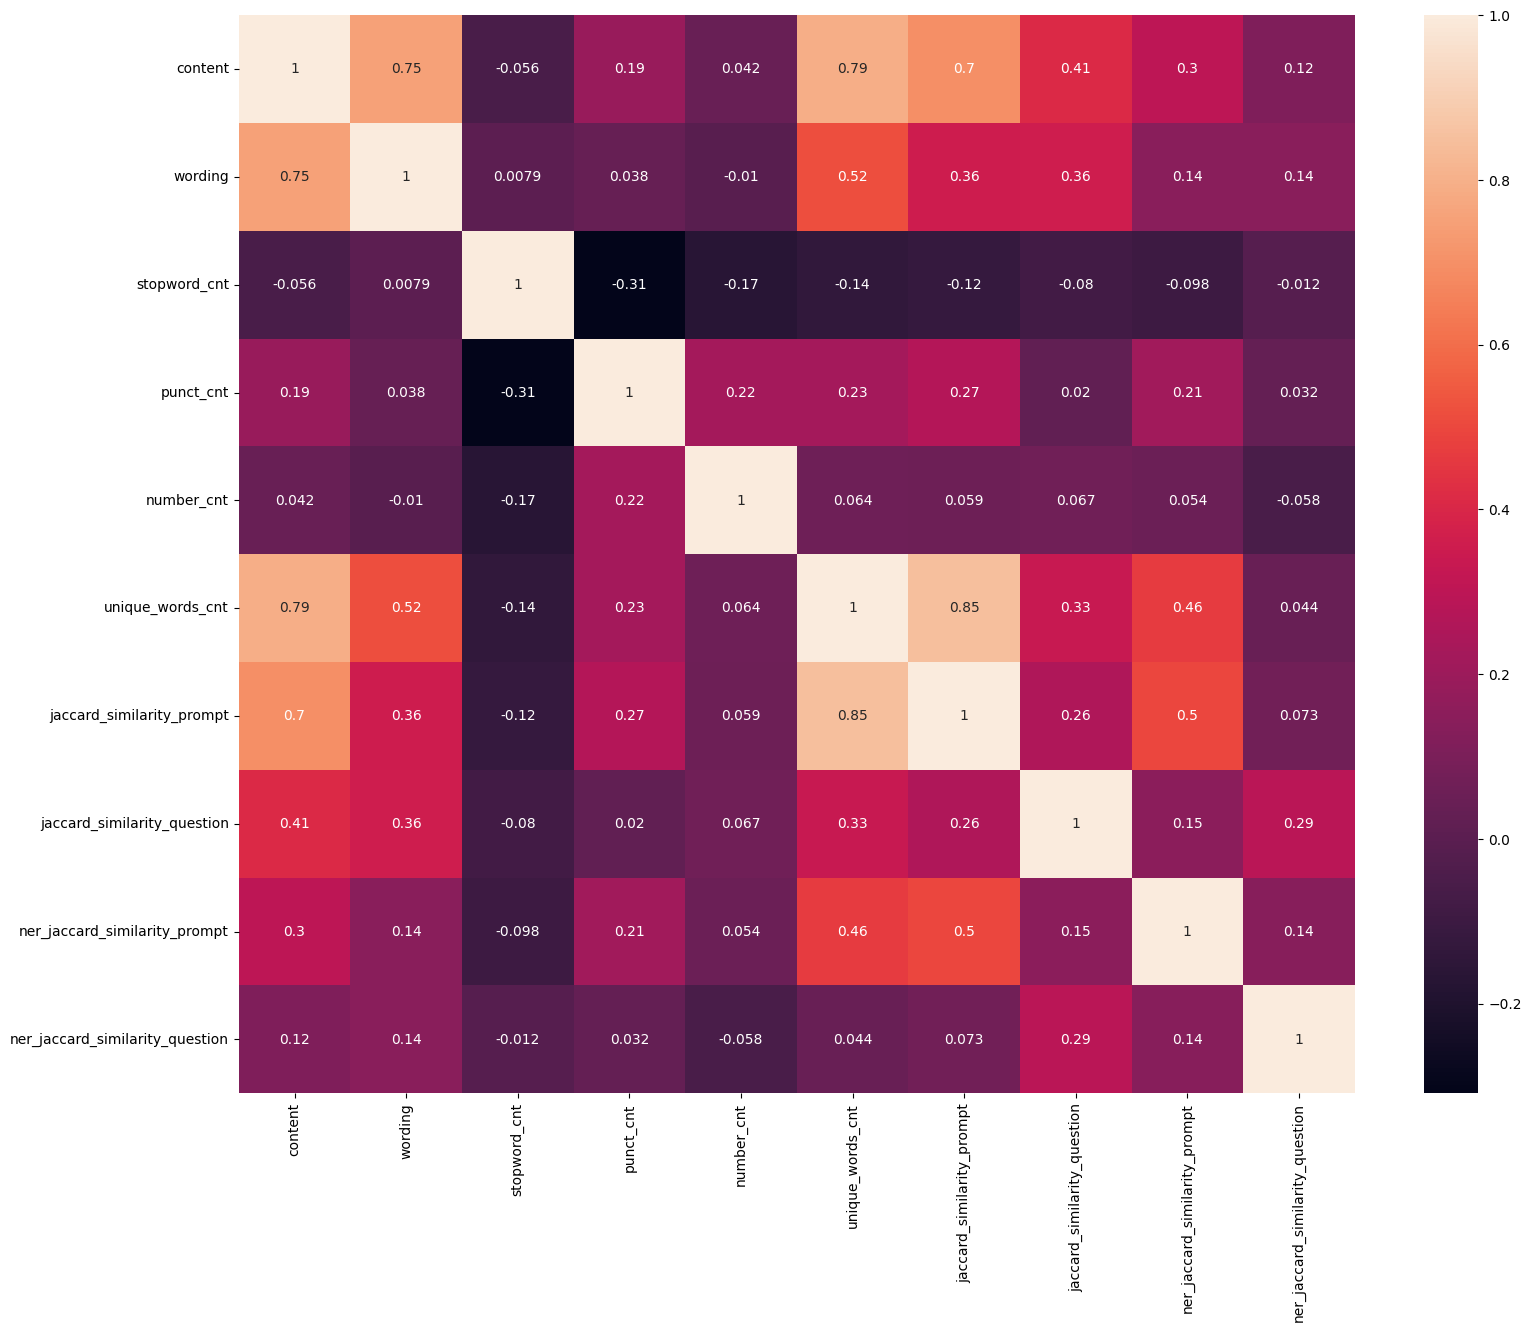

In [11]:
corr = df_train_summaries[TARGETS + FEATURES].corr()
plt.figure(figsize=(18, 14))
sns.heatmap(corr, annot=True);

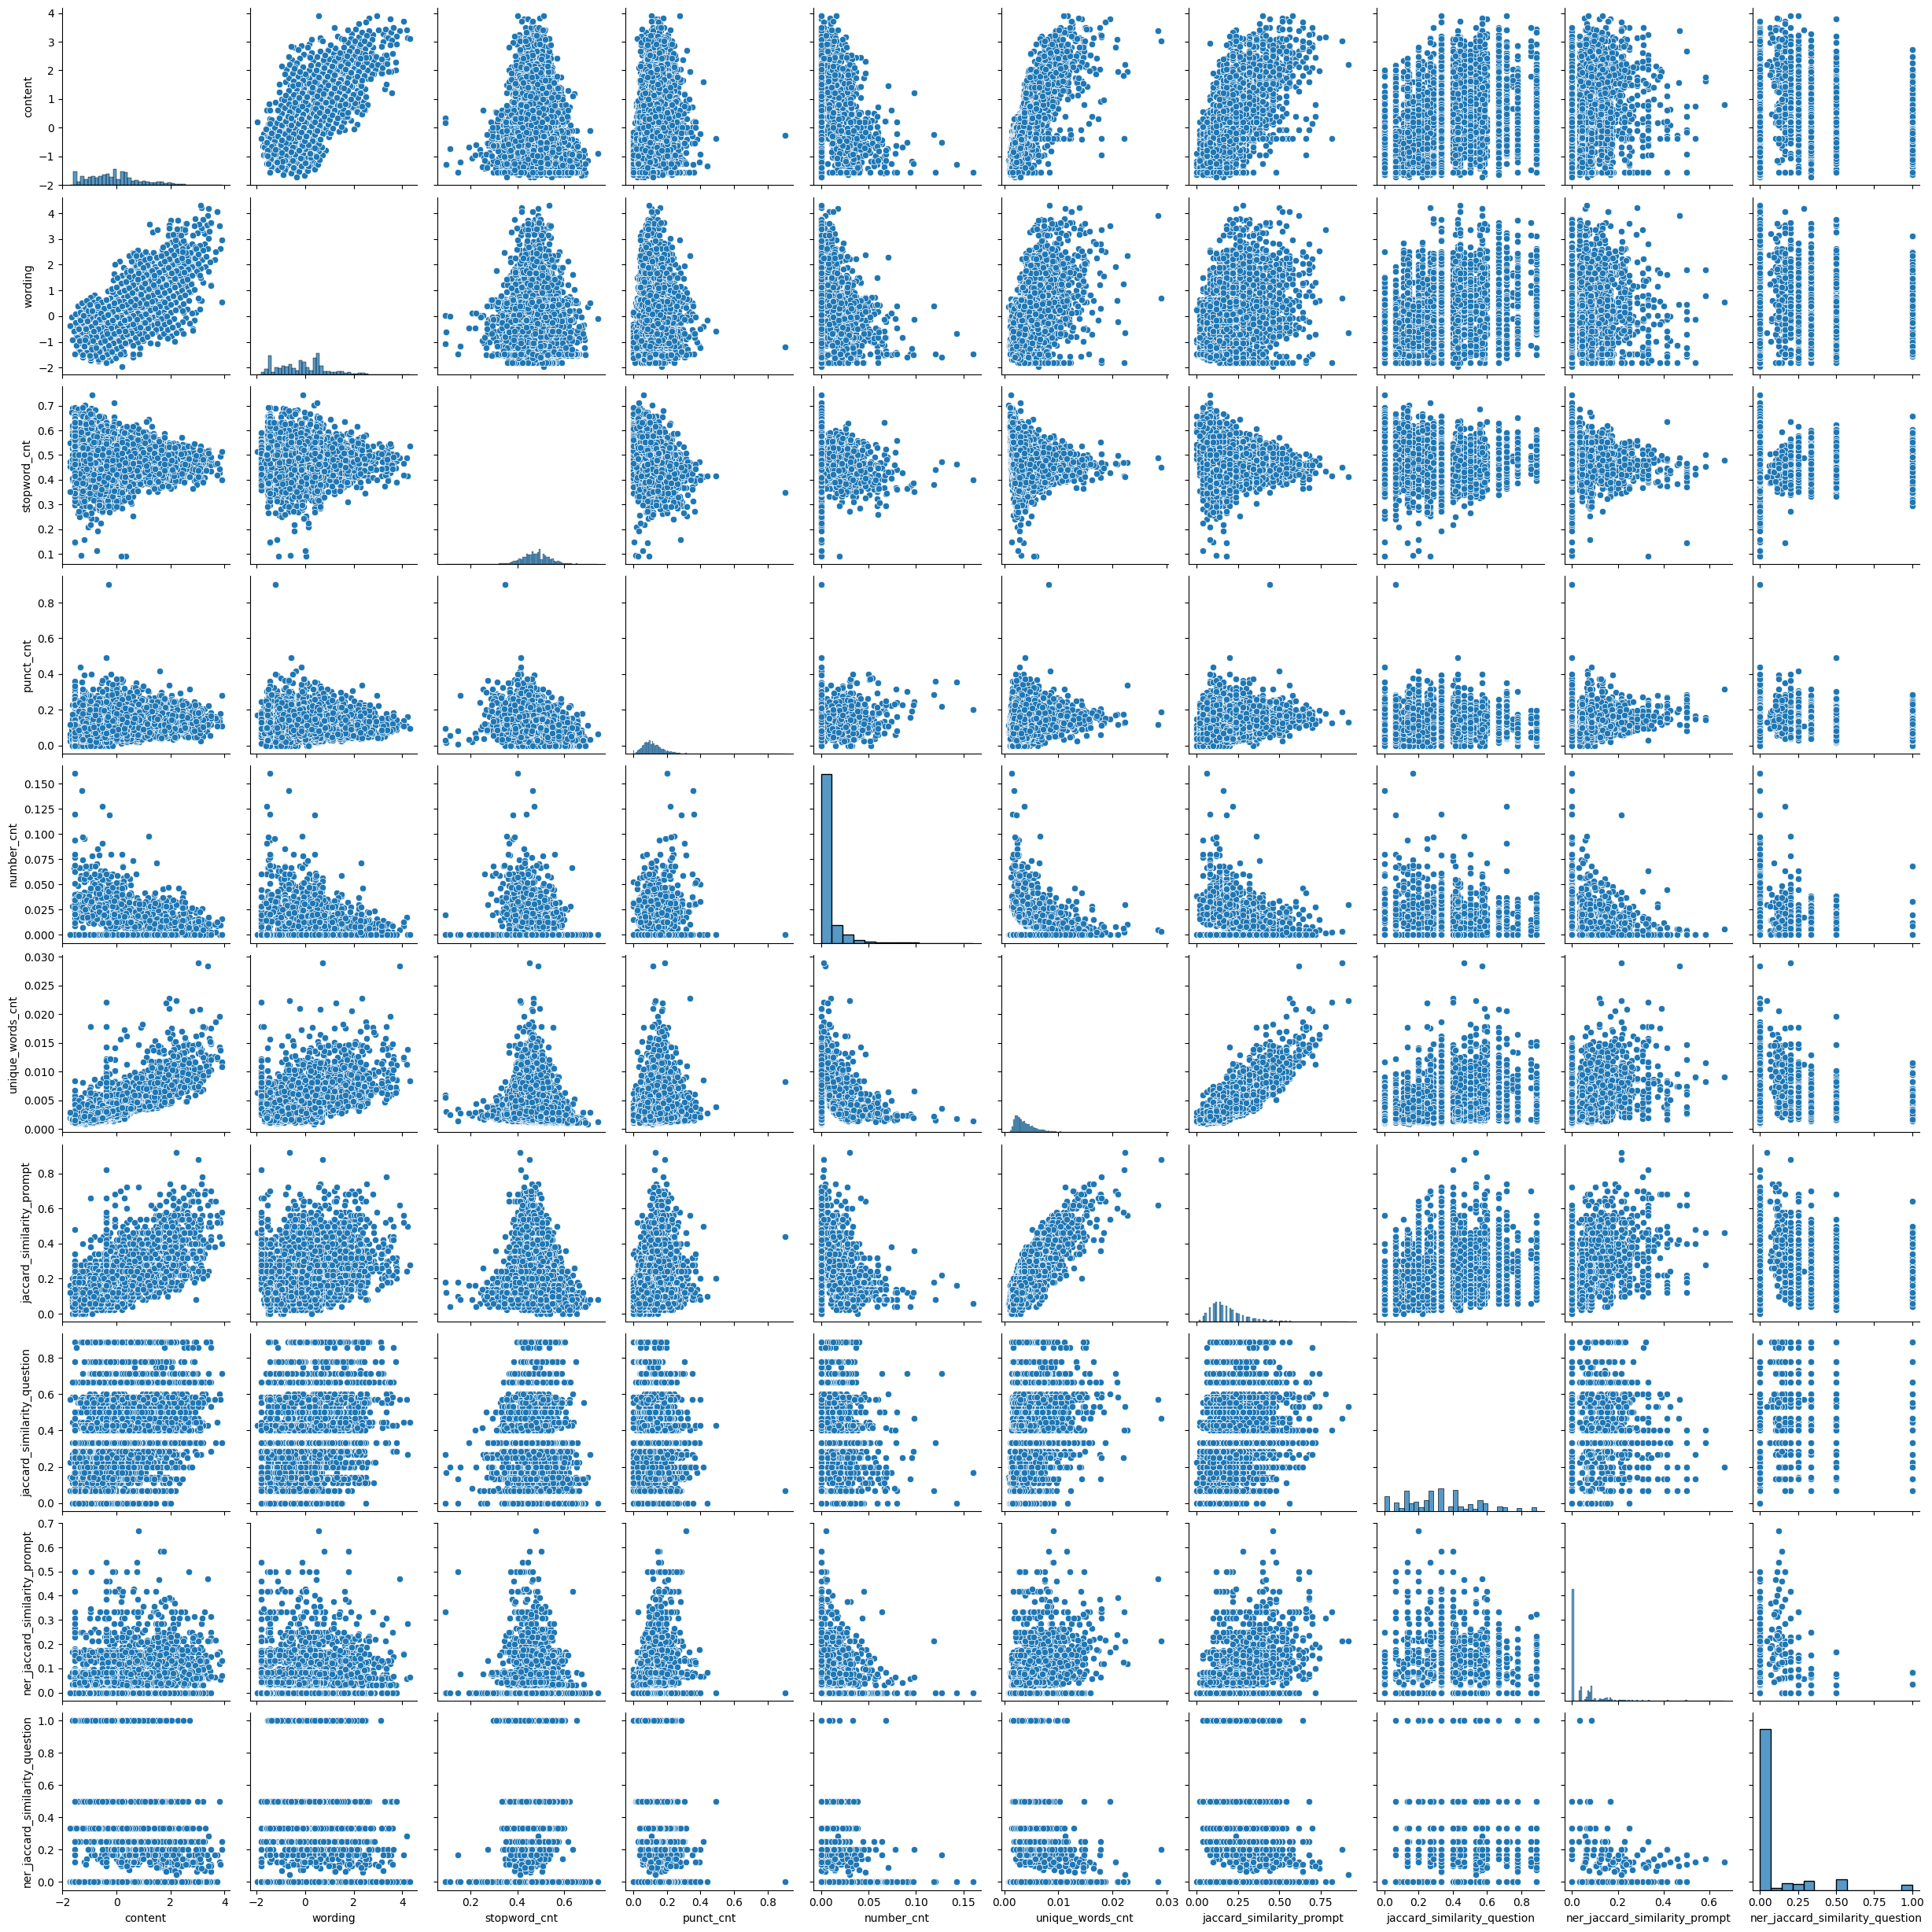

In [12]:
sns.pairplot(df_train_summaries[TARGETS + FEATURES])

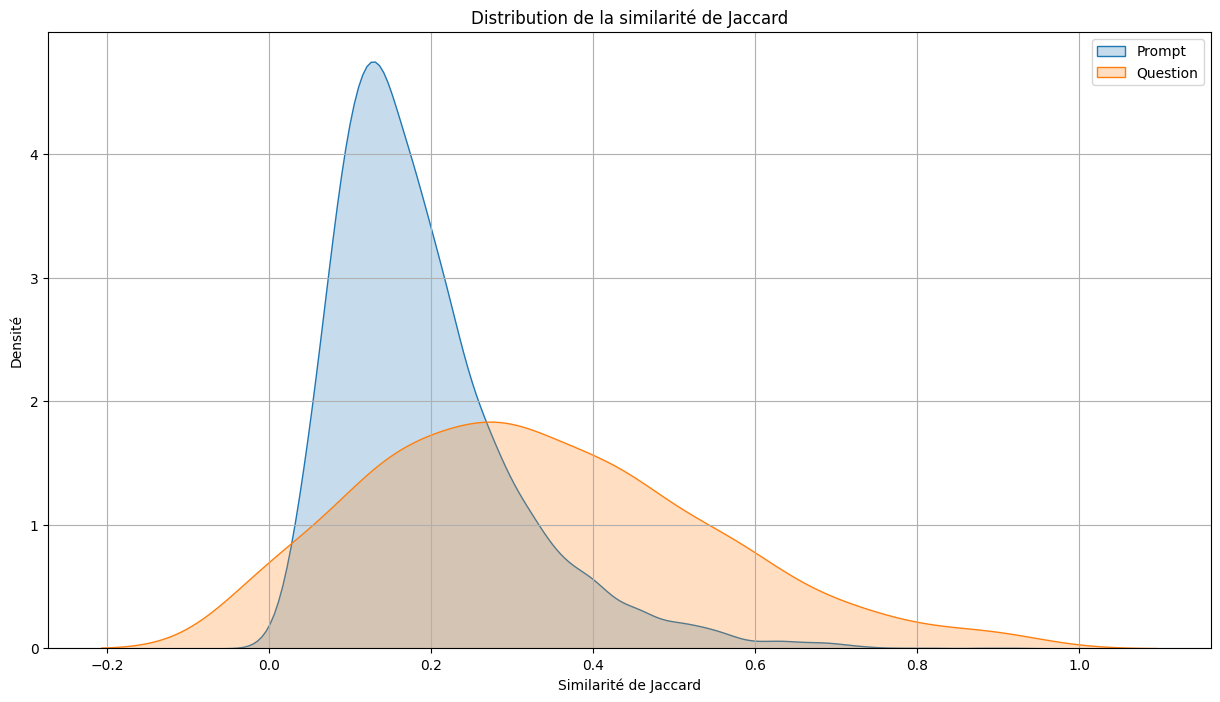

In [13]:
plt.figure(figsize=(15,8))
sns.kdeplot(df_train_summaries['jaccard_similarity_prompt'], fill=True, label="Prompt")
sns.kdeplot(df_train_summaries['jaccard_similarity_question'], fill=True, label="Question", bw_adjust=2)
plt.title("Distribution de la similarité de Jaccard")
plt.xlabel('Similarité de Jaccard')
plt.ylabel('Densité')
plt.legend()
plt.grid()

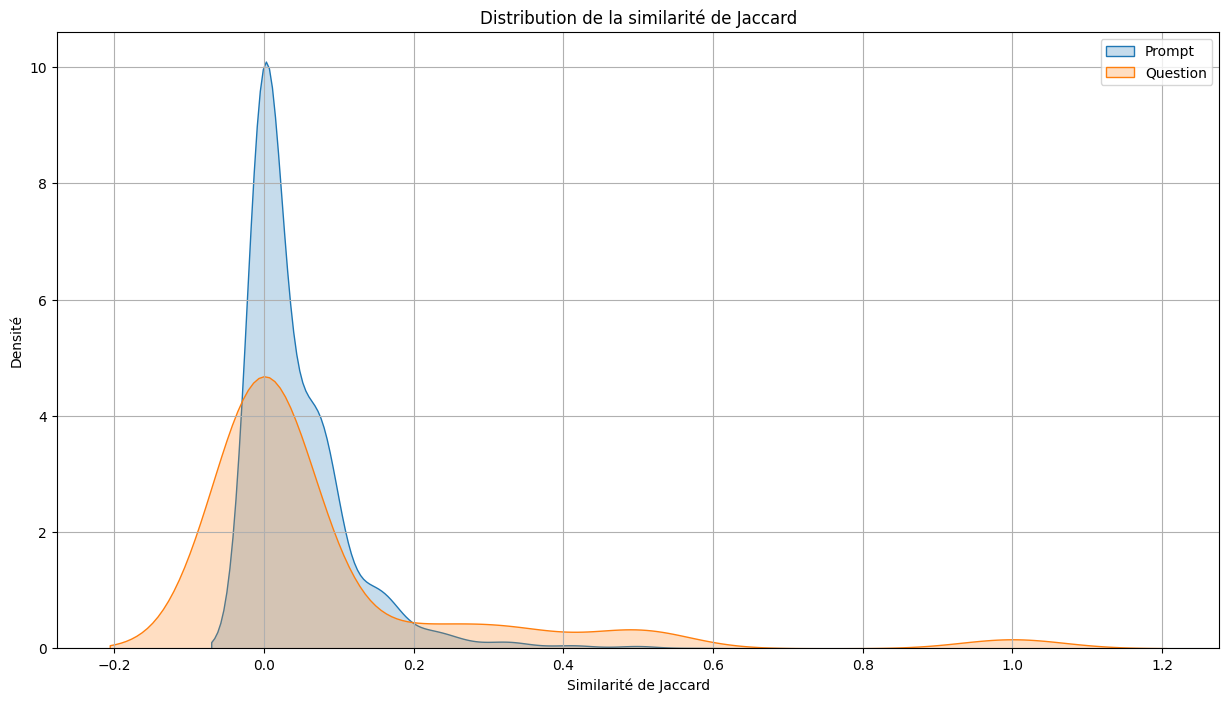

In [15]:
plt.figure(figsize=(15,8))
sns.kdeplot(df_train_summaries['ner_jaccard_similarity_prompt'], fill=True, label="Prompt", bw_adjust=2)
sns.kdeplot(df_train_summaries['ner_jaccard_similarity_question'], fill=True, label="Question", bw_adjust=2)
plt.title("Distribution de la similarité de Jaccard")
plt.xlabel('Similarité de Jaccard')
plt.ylabel('Densité')
plt.legend()
plt.grid()

In [16]:
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(df_train_summaries[TARGETS + FEATURES])

train_ds_pd_content = train_ds_pd.drop(columns='wording')
train_ds_pd_wording = train_ds_pd.drop(columns='content')

# Convert dataframes to corresponding datasets
content_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd_content, label='content', task = tfdf.keras.Task.REGRESSION)
wording_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd_wording, label='wording', task = tfdf.keras.Task.REGRESSION)

2024-02-11 23:07:08.396786: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-11 23:07:08.407421: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-11 23:07:08.407475: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-11 23:07:08.414018: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-11 23:07:08.414164: I external/local_xla/xla/stream_executor

In [17]:
# Create RandomForestModel for label content
model_content = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
model_content.compile(metrics=["mse"])

# Create RandomForestModel for label wording
model_wording = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
model_wording.compile(metrics=["mse"])

Use /tmp/tmprfwvqbtu as temporary training directory


Use /tmp/tmpa0xg77c1 as temporary training directory


In [18]:
# Training RandomForestModel for label content
model_content.fit(x=content_train_ds)

# Training RandomForestModel for label wording
model_wording.fit(x=wording_train_ds)

Reading training dataset...


Training dataset read in 0:00:04.097757. Found 5768 examples.
Training model...


[INFO 24-02-11 23:07:21.6654 CET kernel.cc:1233] Loading model from path /tmp/tmprfwvqbtu/model/ with prefix 7b59bc8df7284cf7


Model trained in 0:00:02.036628
Compiling model...


[INFO 24-02-11 23:07:22.2457 CET decision_forest.cc:660] Model loaded with 300 root(s), 498466 node(s), and 8 input feature(s).
[INFO 24-02-11 23:07:22.2458 CET abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-02-11 23:07:22.2459 CET kernel.cc:1061] Use fast generic engine


Model compiled.
Reading training dataset...
Training dataset read in 0:00:00.189267. Found 5768 examples.
Training model...


[INFO 24-02-11 23:07:24.5654 CET kernel.cc:1233] Loading model from path /tmp/tmpa0xg77c1/model/ with prefix 2aa8315cc5774a4e


Model trained in 0:00:01.471563
Compiling model...


[INFO 24-02-11 23:07:24.9650 CET decision_forest.cc:660] Model loaded with 300 root(s), 479370 node(s), and 8 input feature(s).
[INFO 24-02-11 23:07:24.9650 CET kernel.cc:1061] Use fast generic engine


Model compiled.


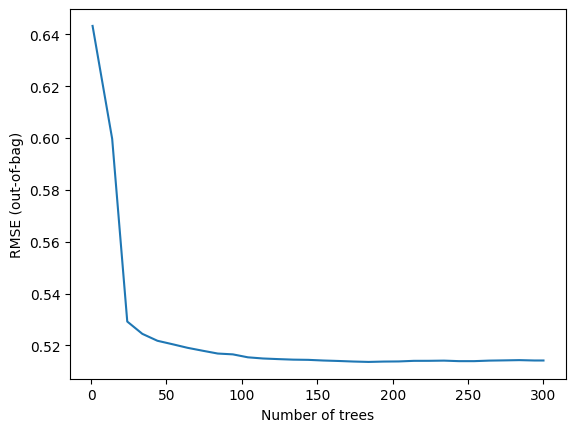

In [19]:
# Plot log data for model_content
logs = model_content.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

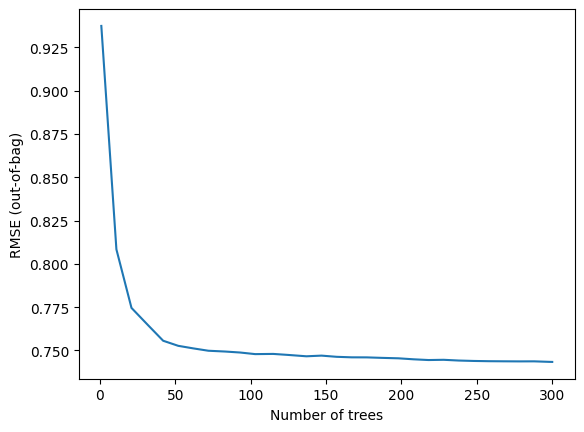

In [20]:
# Plot log data for model_wording
logs = model_wording.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [21]:
# General stats for model_content
inspector_content = model_content.make_inspector()
inspector_content.evaluation()

Evaluation(num_examples=5768, accuracy=None, loss=None, rmse=0.5141688917272832, ndcg=None, aucs=None, auuc=None, qini=None)

In [22]:
# General stats for model_wording
inspector_wording = model_wording.make_inspector()
inspector_wording.evaluation()

Evaluation(num_examples=5768, accuracy=None, loss=None, rmse=0.7434026829973909, ndcg=None, aucs=None, auuc=None, qini=None)

In [23]:
# Create validation dataset for model_content
valid_ds_content = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label="content", task = tfdf.keras.Task.REGRESSION)

# Create validation dataset for model_wording
valid_ds_wording = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label="wording", task = tfdf.keras.Task.REGRESSION)

# Run evaluation for model_content
evaluation_content = model_content.evaluate(x=valid_ds_content,return_dict=True)
for name, value in evaluation_content.items():
  print(f"{name}: {value:.4f}")

# Run evaluation for model_wording
evaluation_wording = model_wording.evaluate(x=valid_ds_wording,return_dict=True)
for name, value in evaluation_wording.items():
  print(f"{name}: {value:.4f}")

2/2 [==============================] - 1s 29ms/step - loss: 0.0000e+00 - mse: 0.2674
loss: 0.0000
mse: 0.2674
2/2 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - mse: 0.5396
loss: 0.0000
mse: 0.5396


In [24]:
def calculate_r_squared(mse, target):
    target_mean = np.mean(target)
    total_sum_of_squares = np.sum((target - target_mean) ** 2)
    r_squared = 1 - (mse*len(target) / total_sum_of_squares)
    return r_squared

r2_content = calculate_r_squared(evaluation_content['mse'], df_train_summaries['content'])
r2_wording = calculate_r_squared(evaluation_wording['mse'], df_train_summaries['wording'])
print(r2_content, r2_wording)

0.7544442704412526 0.49719536324516556


In [26]:
inspector_content.variable_importances()["NUM_AS_ROOT"]

[("unique_words_cnt" (1; #8), 155.0),
 ("jaccard_similarity_prompt" (1; #1), 70.0),
 ("jaccard_similarity_question" (1; #2), 50.0),
 ("ner_jaccard_similarity_prompt" (1; #3), 21.0),
 ("punct_cnt" (1; #6), 3.0),
 ("number_cnt" (1; #5), 1.0)]

In [27]:
inspector_wording.variable_importances()["NUM_AS_ROOT"]

[("unique_words_cnt" (1; #8), 155.0),
 ("jaccard_similarity_prompt" (1; #1), 67.0),
 ("jaccard_similarity_question" (1; #2), 54.0),
 ("ner_jaccard_similarity_prompt" (1; #3), 20.0),
 ("ner_jaccard_similarity_question" (1; #4), 2.0),
 ("punct_cnt" (1; #6), 2.0)]